# Growth curve analysis of pools

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

## Specify paths

In [2]:
layout_path = '20220412_layout_single.xlsx'
source_data = {'BY4741':'20220408_DMS_single_pools.xlsx',
               'R1158':'20220414_DMS_single_pools_DOX.xlsx'
              }
graph_outpath = '../manuscript_figures/'

## Get layout

In [3]:
layout = pd.read_excel(layout_path, header=0)
layout

,well,compound,concentration,inhibition_coefficient,strain,genotype
0,B2,caspofungin,0.039,0.50,BY4741,WT
1,B3,caspofungin,0.030,0.25,BY4741,WT
2,B4,caspofungin,0.022,0.10,BY4741,WT
3,B5,micafungin,0.290,0.50,BY4741,WT
4,B6,micafungin,0.220,0.25,BY4741,WT
...,...,...,...,...,...,...
115,F9,anidulafungin,0.300,0.25,R1158,delta-FKS2-HS2
116,F10,anidulafungin,0.220,0.10,R1158,delta-FKS2-HS2
117,F11,caspofungin,0.000,0.00,R1158,delta-FKS2-HS2
118,F11,micafungin,0.000,0.00,R1158,delta-FKS2-HS2


## Get plate reader data

In [4]:
def get_data(fpath):
    df = pd.read_excel(fpath, header=1, index_col=0,skiprows=[2])
    df.rename(columns=lambda x: float(x.strip('s'))/3600, inplace=True)
    longdf = df.reset_index().rename(columns = {'index' : 'well'})
    longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD')
    return longdf

In [5]:
df_list = []

for k,v in source_data.items():
        df = get_data(v)
        df['strain'] = k
        df_list.append(df)

fulldf = pd.concat(df_list, ignore_index=True) 
fulldf

,well,time (h),OD,strain
0,B2,0.0,0.093875,BY4741
1,B3,0.0,0.101950,BY4741
2,B4,0.0,0.095450,BY4741
3,B5,0.0,0.098200,BY4741
4,B6,0.0,0.095850,BY4741
...,...,...,...,...
28315,G7,46.756111,0.078550,R1158
28316,G8,46.756111,0.079375,R1158
28317,G9,46.756111,0.077825,R1158
28318,G10,46.756111,0.077925,R1158


## Annotate data

In [6]:
annotdf = fulldf.merge(right=layout, on=['strain','well'])
annotdf

,well,time (h),OD,strain,compound,concentration,inhibition_coefficient,genotype
0,B2,0.0,0.093875,BY4741,caspofungin,0.039,0.5,WT
1,B2,0.25,0.096825,BY4741,caspofungin,0.039,0.5,WT
2,B2,0.5,0.097850,BY4741,caspofungin,0.039,0.5,WT
3,B2,0.75,0.098900,BY4741,caspofungin,0.039,0.5,WT
4,B2,1.0,0.100100,BY4741,caspofungin,0.039,0.5,WT
...,...,...,...,...,...,...,...,...
28315,F11,46.506111,0.985100,R1158,micafungin,0.000,0.0,delta-FKS2-HS2
28316,F11,46.506111,0.985100,R1158,anidulafungin,0.000,0.0,delta-FKS2-HS2
28317,F11,46.756111,0.985130,R1158,caspofungin,0.000,0.0,delta-FKS2-HS2
28318,F11,46.756111,0.985130,R1158,micafungin,0.000,0.0,delta-FKS2-HS2


## Visualize growth curves

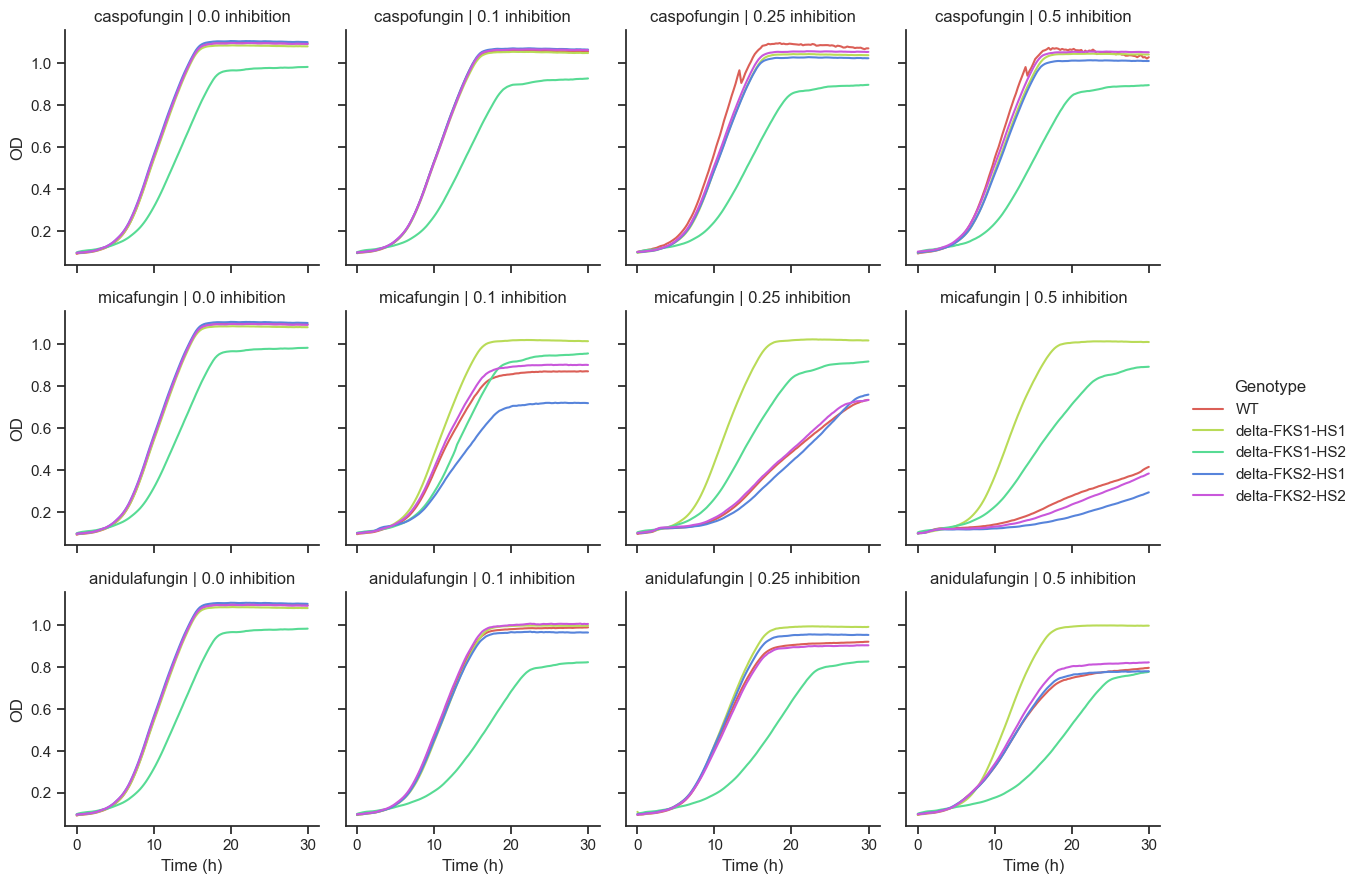

In [7]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

grid = sns.FacetGrid(data=annotdf[(annotdf.strain == 'BY4741')
                                  & (annotdf['time (h)'] <=30)
                                 ],
                     row = 'compound', col = 'inhibition_coefficient',
                     hue='genotype', palette='hls')
grid.map(sns.lineplot, 'time (h)', 'OD')

grid.set_titles(row_template='{row_name}', col_template='{col_name} inhibition')
grid.set_axis_labels('Time (h)', 'OD')
grid.add_legend(title = 'Genotype')
grid.fig.subplots_adjust(top=0.9)
grid.tight_layout()

## Calculate normalized area under the curve (AUC)

In [8]:
def get_auc(g):
    import numpy as np
    return np.trapz(g.OD)

In [9]:
aucdf = annotdf[(annotdf['time (h)'] > .25)
                & (annotdf['time (h)'] <= 30)
               ].groupby(['strain','genotype','inhibition_coefficient','compound','well']
                        )[['OD']].apply(func=get_auc).reset_index(name='auc')
aucdf

,strain,genotype,inhibition_coefficient,compound,well,auc
0,BY4741,WT,0.00,anidulafungin,B11,89.720893
1,BY4741,WT,0.00,caspofungin,B11,89.720893
2,BY4741,WT,0.00,micafungin,B11,89.720893
3,BY4741,WT,0.10,anidulafungin,B10,79.919188
4,BY4741,WT,0.10,caspofungin,B4,87.002425
...,...,...,...,...,...,...
115,R1158,delta-FKS2-HS2,0.25,caspofungin,F3,64.466850
116,R1158,delta-FKS2-HS2,0.25,micafungin,F6,70.103660
117,R1158,delta-FKS2-HS2,0.50,anidulafungin,F8,38.727500
118,R1158,delta-FKS2-HS2,0.50,caspofungin,F2,61.521780


In [10]:
def get_l2fc(val, s, comp, ic, df):    
    import numpy as np
    
    # Retrieve corresponding WT value for the condition
    wt = df.loc[(df.strain == s)
                & (df.compound == comp)
                & (df.inhibition_coefficient == ic)
                & (df.genotype == 'WT'),
                'auc'
               ].values
    
    # Make sure a single value was extracted
    if len(wt) == 1:
        # Return log2 fold-change
        return np.log2(val/wt[0])
    else:
        return 'error'

In [11]:
aucdf['L2FC'] = aucdf.apply(lambda row: get_l2fc(row.auc, row.strain, row.compound, row.inhibition_coefficient, aucdf), axis=1)
aucdf

,strain,genotype,inhibition_coefficient,compound,well,auc,L2FC
0,BY4741,WT,0.00,anidulafungin,B11,89.720893,0.000000
1,BY4741,WT,0.00,caspofungin,B11,89.720893,0.000000
2,BY4741,WT,0.00,micafungin,B11,89.720893,0.000000
3,BY4741,WT,0.10,anidulafungin,B10,79.919188,0.000000
4,BY4741,WT,0.10,caspofungin,B4,87.002425,0.000000
...,...,...,...,...,...,...,...
115,R1158,delta-FKS2-HS2,0.25,caspofungin,F3,64.466850,0.247573
116,R1158,delta-FKS2-HS2,0.25,micafungin,F6,70.103660,0.565586
117,R1158,delta-FKS2-HS2,0.50,anidulafungin,F8,38.727500,0.793643
118,R1158,delta-FKS2-HS2,0.50,caspofungin,F2,61.521780,0.320886


## Visualize AUC

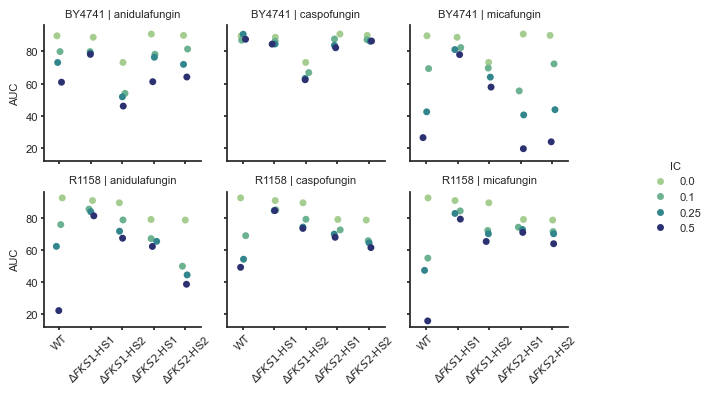

In [14]:
sns.set(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

fig = sns.catplot(aucdf,
                  x='genotype', y='auc',
                  order=['WT','delta-FKS1-HS1','delta-FKS1-HS2','delta-FKS2-HS1','delta-FKS2-HS2'],
                  row='strain', col='compound',
                  hue='inhibition_coefficient', palette='crest',
                  height=2
                 )
fig.set_titles(row_template='{row_name}', col_template='{col_name}')
fig.set_axis_labels('', 'AUC')
fig.set_xticklabels(['WT',u'Δ$\\it{FKS1}$-HS1',u'Δ$\\it{FKS1}$-HS2',u'Δ$\\it{FKS2}$-HS1',u'Δ$\\it{FKS2}$-HS2'], rotation=45)
fig._legend.set_title('IC')
fig.fig.subplots_adjust(top=0.9)
fig.tight_layout()

## Visualize log2 fold changes

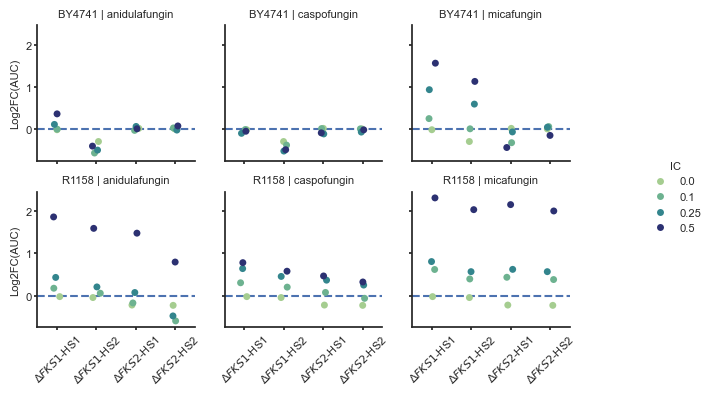

In [12]:
sns.set(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

fig = sns.catplot(aucdf[aucdf.genotype != 'WT'],
                  x='genotype', y='L2FC',
                  order=['delta-FKS1-HS1','delta-FKS1-HS2','delta-FKS2-HS1','delta-FKS2-HS2'],
                  row='strain', col='compound',
                  hue='inhibition_coefficient', palette='crest',
                  height=2
                 )
fig.map(plt.axhline, y=0, linestyle='--')
fig.set_titles(row_template='{row_name}', col_template='{col_name}')
fig.set_axis_labels('', 'Log2FC(AUC)')
fig.set_xticklabels([u'Δ$\\it{FKS1}$-HS1',u'Δ$\\it{FKS1}$-HS2',u'Δ$\\it{FKS2}$-HS1',u'Δ$\\it{FKS2}$-HS2'], rotation=45)
fig._legend.set_title('IC')
fig.fig.subplots_adjust(top=0.9)
fig.tight_layout()